In [49]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import PurePosixPath, PureWindowsPath
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [50]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = int(self.annotations.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


class UnlabeledImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.images = [file.name for file in os.scandir(img_dir)]
        self.img_dir = str(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        image = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

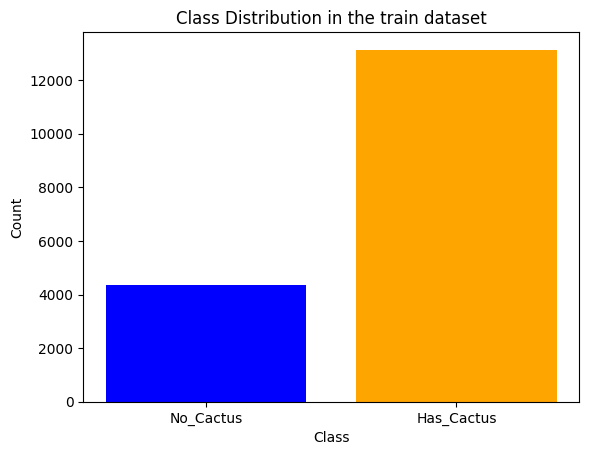

In [51]:
count_0 = 4364  # -> 12000/13000
count_1 = 13136

plt.bar(['No_Cactus', 'Has_Cactus'], [count_0, count_1], color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in the train dataset')
plt.show()

In [52]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])


test_dir = PurePosixPath("/kaggle/input/test-set/test")
if os.name == 'nt':
    test_dir = PureWindowsPath(test_dir)

In [53]:
# Da eseguire solo una volta per generare le immagini augmentate


# train_dataset = CustomImageDataset(
#     csv_file=csv_file,
#     img_dir=train_dir,
#     transform=transform
# )

# dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# print(len(dataloader))

# # Augmentations to apply
# augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(np.random.uniform(0, 45)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
# ])

# output_dir = "data\\train\\train_augmented"
# os.makedirs(output_dir, exist_ok=True)

# # How many new versions of each image to generate?
# num_augmented = 2

# i = 0
# for images, labels in tqdm(dataloader):
#     for (image, label) in zip(images, labels):
#         if label == 0:
#             for j in range(num_augmented):
#                 aug_img = augment(image)
#                 new_filename = f"aug_{i}_{j}.jpg"
#                 aug_img.save(os.path.join(output_dir, new_filename))
#         i+=1

In [54]:
test_dataset = UnlabeledImageDataset(
    img_dir=test_dir,
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


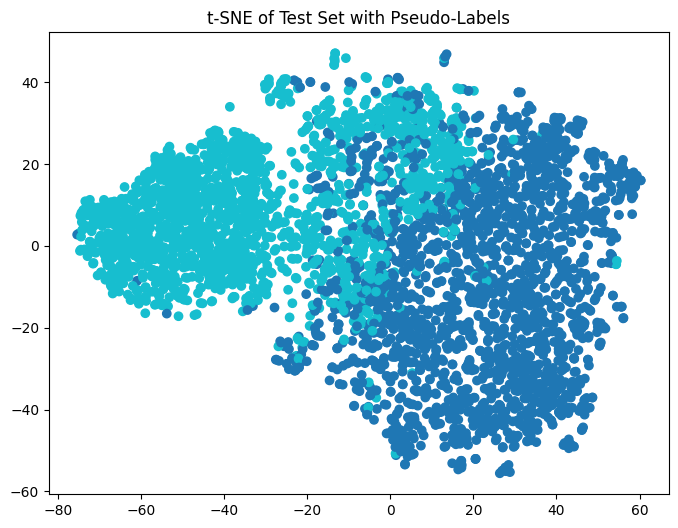

In [57]:
import os
import glob
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import shutil

# 1. Dataset personalizzato per immagini in una sola cartella
class FlatImageDatasetWithPaths(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted(glob.glob(os.path.join(root, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, img_path

# 2. Transform per ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 3. Caricamento immagini
test_dir = "/kaggle/input/test-set/test"
test_dataset = FlatImageDatasetWithPaths(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. Caricamento ResNet18 senza classificatore finale
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval().to(device)

# 5. Estrazione feature
features = []
paths = []

with torch.no_grad():
    for inputs, file_paths in test_loader:
        inputs = inputs.to(device)
        feats = feature_extractor(inputs).view(inputs.size(0), -1)
        features.append(feats.cpu())
        paths.extend(file_paths)

features = torch.cat(features).numpy()

# 6. Clustering KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pseudo_labels = kmeans.fit_predict(features)

# 7. Visualizzazione t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(features)
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pseudo_labels, cmap='tab10')
plt.title("t-SNE of Test Set with Pseudo-Labels")
plt.show()

# 8. Salvataggio CSV
df = pd.DataFrame({
    "path": paths,
    "pseudo_label": pseudo_labels
})
df.to_csv("/kaggle/working/pseudo_labeled_test.csv", index=False)
df.head()
# 9. Salva le immagini nei rispettivi cluster
os.makedirs("/kaggle/working/cluster_0", exist_ok=True)
os.makedirs("/kaggle/working/cluster_1", exist_ok=True)

for path, label in zip(paths, pseudo_labels):
    filename = os.path.basename(path)
    dest_dir = f"/kaggle/working/cluster_{label}"
    shutil.copy(path, os.path.join(dest_dir, filename))

